# Total Variation (TV) denoising

*Louis Martinez*

[Link to the paper](./References/total_variation.pdf)

Here is implemented the total variation denoising based on the class taught by Said Ladjal at Telecom Paris

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from skimage.io import imread, imshow

np.random.seed(0)
random.seed(0)

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

def show_img(ax, im, title):
    ax.axis('off')
    ax.imshow(im)
    ax.set_title(title, fontsize=10)

We want to minimize the following energy function :

$$E(u) = \|u-v\|^2+\lambda\, TV(u)$$

where $v$ is the noisy image and $u$ the denoised image

We minimize $E$ with a gradient descent :

$$\nabla E(u) = 2(u-v)-\lambda\,div\left(\frac{\nabla u}{\|u\|}\right)$$

In [10]:
def gaussian_kernel(s, std):
    """
    Create a 2D centered gaussian kernel

    s : size of the kernel (must be odd)
    std : standard deviation of the kernel
    """
    K = np.fromfunction(lambda x, y : (1/(2*np.pi*std**2)) * np.exp(-((x-(s//2))**2+(y-(s//2))**2) / (2*std**2)), (s, s))
    return K/np.sum(K)


def apply_filter(im, K):
    """
    Aplies a filter kernel to an image 

    K : 2D kernel to apply to the image
    im : grayscale image which filter to be applied
    """
    w, h = im.shape
    im_ft = np.fft.fft2(im)
    K_ft = np.fft.fft2(K, [w, h])
    return np.real(np.fft.ifft2(im_ft * K_ft))

def norm2(im):
    return ((im**2).sum())**0.5


def gradient(im):
    w, h = im.shape
    grad_x = np.zeros((w, h))
    grad_x[:,:-1] = im[:,1:]-im[:,:-1]
    grad_x[:,-1] = np.zeros((w,))

    
    grad_y = np.zeros((w, h))
    grad_y[:-1,:] = im[1:,:]-im[:-1,:]
    grad_y[-1,:] = np.zeros((h,))

    return np.stack([grad_x, grad_y], axis=2).transpose(2, 0, 1)

def random_noise(im,noise): 
    """
    Add gaussian noise to an image
    """
    out=im+noise*np.random.randn(*im.shape)
    return out

def divergence(gx, gy):
    r, c = gx.shape

    dx = np.zeros((r, c))
    dx[:,1:-1] = gx[:,1:-1]-gx[:,:-2]
    dx[:,0] = gx[:,0]
    dx[:,-1] = -gx[:,-2]

    dy = np.zeros((r, c))
    dy[1:-1,:] = gy[1:-1,:]-gy[:-2,:]
    dy[0,:] = gy[0,:]
    dy[-1,:] = -gy[-2,:]
    return dx+dy

def TV_norm(im):
    gx, gy = gradient(im)
    norm = np.sum((gx**2 + gy**2)**0.5)
    return norm

def energy(u,v,lamb):
    return norm2(u-v)**2 + lamb * TV_norm(u)

def energy_grad(u,v,lamb):
    """
        v       : noisy image
        u       : denoised image
        lamb    : constant for TV
    """
    gx, gy = gradient(u)
    norm = ((gx**2)+(gy**2))**0.5 + 1e-15
    div = divergence(gx/norm, gy/norm)
    return 2*(u-v) - lamb*div

def minimize_TV(v, lamb, step, n_steps):
    """
        v       : image to denoise
        lamb    : mltlicative constant TV
        step    : update step
        n_steps : number of steps
    """
    u = np.zeros(v.shape)
    energies = [energy(u,v,lamb)]

    for i in tqdm(range(n_steps)):
        u = u - step * energy_grad(u,v,lamb)
        energies.append(energy(u,v,lamb))

    return u, energies

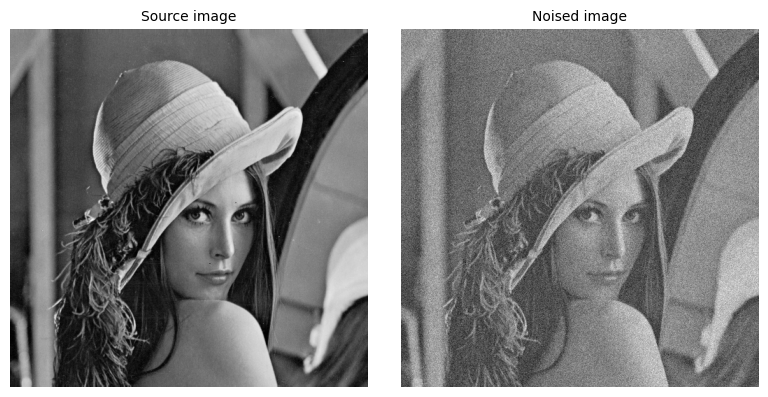

In [11]:
im = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/default_images/lena.tif')
im_n = random_noise(im, 25)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
show_img(ax[0], im, 'Source image')
show_img(ax[1], im_n, 'Noised image')
plt.tight_layout()
plt.show()

100%|██████████| 200/200 [00:04<00:00, 49.64it/s]


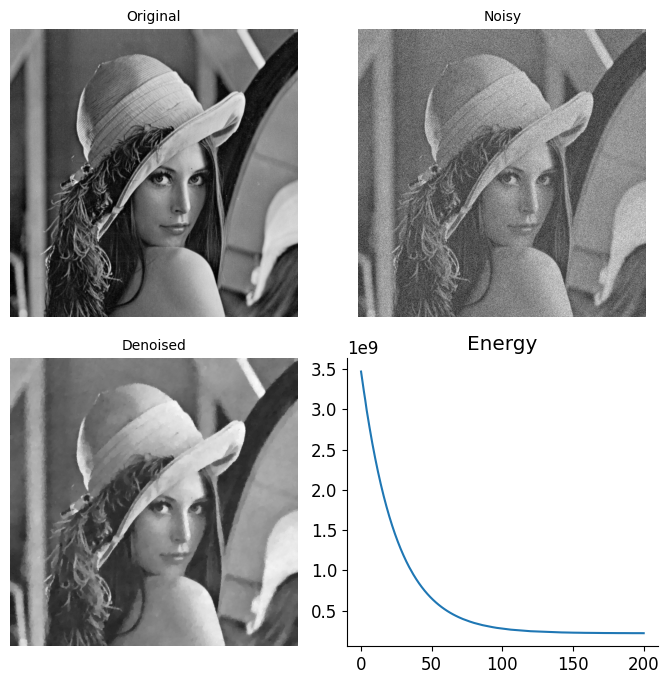

In [12]:
denoised, energies = minimize_TV(im_n, lamb=50, step=0.01, n_steps=200)
fig, axes = plt.subplots(2, 2, figsize=(7,7))
ax = axes.ravel()
show_img(ax[0], im, 'Original')
show_img(ax[1], im_n, 'Noisy')
show_img(ax[2], denoised, 'Denoised')
ax[3].plot(energies)
ax[3].set_title('Energy')
plt.tight_layout()
plt.show()

---
## Using torch autograd

We leverage the PyTorch auto-differentiation package to denoise the image instead of computing the gradient in closed form. However, even after a comprehensive grid-search, we were unable to find an optimal set of hyperparameters $(lr,\lambda)$. The final result turns out to be either an extremely blurry version of the target image, or just noise.

The functions below have the following conventions:  
- `v`: Input image
- `u`: image to optimize, converging to a denoised version of the input image =

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

In [14]:
im = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/default_images/lena.tif')
im_n = random_noise(im, 25)

im_n = 255 * T.ToTensor()(im_n[...,None])

In [15]:
def gradient(im):
    _, w, h = im.shape # (1,512,512)
    grad_x = torch.zeros((w, h))
    grad_x[:,:-1] = im[0,:,1:]-im[0,:,:-1]
    grad_x[:,-1] = torch.zeros((w,))

    grad_y = torch.zeros((w, h))
    grad_y[:-1,:] = im[0,1:,:]-im[0,:-1,:]
    grad_y[-1,:] = torch.zeros((h,))

    return grad_x, grad_y

def TV_loss(u):
    gx, gy = gradient(u) # (512,512)
    norm = torch.sum(gx**2 + gy**2)**0.5
    return norm

def compute_loss(u, v, lamb):
    return F.mse_loss(u, v) + lamb * TV_loss(u)


def optimize(v, lamb, lr, n_steps):
    losses = np.zeros(n_steps)
    samples = []
    u = torch.randn_like(v, requires_grad=True)
    
    for step in tqdm(range(n_steps)):
        loss = compute_loss(u, v, lamb)
        loss.backward()
        with torch.no_grad():
            u -= lr * u.grad
        u.grad.zero_()

        losses[step] = loss.item()
        
    return u.detach().squeeze(0), losses
    
res, losses = optimize(im_n, lamb=5, lr=15.5, n_steps=300)

100%|██████████| 300/300 [00:02<00:00, 115.71it/s]


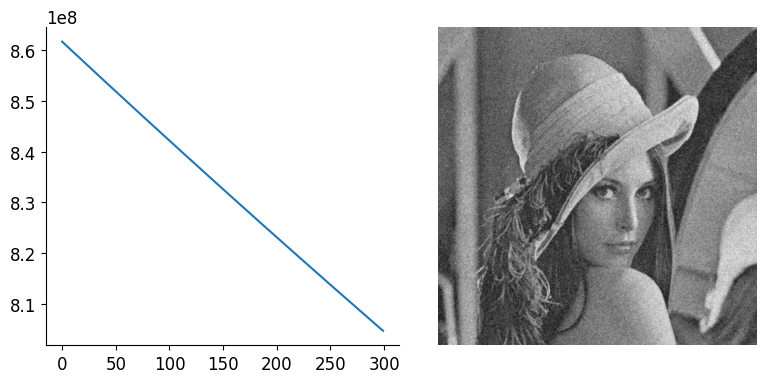

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.plot(losses)
ax2.axis('off')
ax2.imshow(res)
plt.tight_layout()
plt.show()